# Initial Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# importing the cleaned reddit posts
posts = pd.read_csv("../data/cleaned_reddit_posts.csv")

X = posts["title"]
y = posts["subreddit"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=2020)

#Calculating the baseline accuracy of the data
y_test.value_counts(normalize=True)

0    0.506923
1    0.493077
Name: subreddit, dtype: float64

In [2]:
stopwords = nltk.corpus.stopwords.words('english')
# adding eli5, aita, and wibta to the stopwords
stopwords.extend(['eli5','aita','wibta','friend'])

The first iteration the best parameters 
'cvec__max_df': 0.9, 
'cvec__max_features': 3000, 
'cvec__min_df': 2, 
'cvec__ngram_range': (1, 1)

Over all initial attempts the ngram has always been 1. Going to remove it until further tests

### Fitting using Logistic Regressiton and Cvec in a pipeline

In [3]:
# Used to create dictionary of model params and counter
logreg_model_df = pd.read_csv("../data/logreg_model_params.csv")

#getting the index from the nb_model_params and saving it to a count
logreg_count = logreg_model_df.tail(1).index.values[0]

In [4]:
logreg_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords)),
    ('logreg', LogisticRegression(penalty="l2",solver="liblinear"))
])

logreg_pipe_params = {
    "cvec__max_features" : [2000],
    "cvec__min_df" : [2],
    "cvec__max_df" : [.80],
    "logreg__C" : [.1]
}

temp_dict = {}
t0 = time.time()

logreg_gs = GridSearchCV(logreg_pipe,param_grid=logreg_pipe_params,cv=5,verbose=1)

logreg_gs.fit(X_train,y_train)

best_logreg = logreg_gs.best_estimator_

logreg_count += 1

logreg_gs.best_params_["train score"] = best_logreg.score(X_train,y_train)
logreg_gs.best_params_["test score"] = best_logreg.score(X_test,y_test)
temp_dict[f'model_{logreg_count}'] = logreg_gs.best_params_

temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
logreg_model_df = pd.concat([logreg_model_df,temp_df])

t1 = time.time()
print(f'This took {t1-t0} seconds!')

logreg_model_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


This took 1.122307538986206 seconds!


,cvec__max_df,cvec__max_features,cvec__min_df,train score,test score,logreg__C
0,0.7,3000,2,0.970000,0.923462,NaN
1,0.7,2500,3,0.966667,0.922308,NaN
2,0.7,2000,4,0.961026,0.919615,NaN
3,0.6,2000,4,0.961026,0.919615,NaN
4,0.8,1500,3,0.951154,0.913077,NaN
5,0.8,2000,4,0.961026,0.919615,1.0
6,0.8,2000,3,0.950769,0.915385,0.5
7,0.8,2000,3,0.926538,0.901154,0.1
8,0.8,2500,3,0.929359,0.904231,0.1
9,0.8,3000,3,0.932821,0.905000,0.1


In [5]:
logreg_model_df.to_csv("../data/logreg_model_params.csv",index=False)

In [6]:
#using named_steps dict to access attributes 
#https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn
#https://stackoverflow.com/questions/35376293/extracting-selected-feature-names-from-scikit-pipeline
classifier = best_logreg.named_steps['logreg']
vectorizer = best_logreg.named_steps['cvec']
classifier.coef_
vectorizer.get_feature_names()
coefs = pd.DataFrame(classifier.coef_[0],index=vectorizer.get_feature_names())

In [20]:
#getting the words with have the largest effect on eli5
eli5_words = coefs.sort_values(by=0,ascending=False).head(10)

In [23]:
eli5_words["words"] = eli5_words.index

In [27]:
eli5_words["times_likely"] = np.exp(eli5_words[0])

In [28]:
eli5_words

,0,words,times_likely
people,1.132763,people,3.104222
difference,1.051724,difference,2.862582
work,0.968770,work,2.634702
different,0.966505,different,2.628741
water,0.845870,water,2.330004
body,0.826744,body,2.285864
mean,0.773869,mean,2.168139
humans,0.746837,humans,2.110314
like,0.740270,like,2.096502
exactly,0.736941,exactly,2.089533


In [30]:
#getting the words which have the largest effect on aita
aita_words = coefs.sort_values(by=0,ascending=False).tail(10)
aita_words["words"] = aita_words.index
aita_words["times_likely"] = np.exp(np.abs(aita_words[0]))
aita_words

,0,words,times_likely
asking,-1.356941,asking,3.884292
friends,-1.378722,friends,3.969824
brother,-1.387670,brother,4.005507
girlfriend,-1.409322,girlfriend,4.093178
refusing,-1.411496,refusing,4.102087
boyfriend,-1.507879,boyfriend,4.517138
sister,-1.609562,sister,5.000620
mom,-1.661609,mom,5.267781
telling,-2.037597,telling,7.672151
wanting,-2.221222,wanting,9.218591


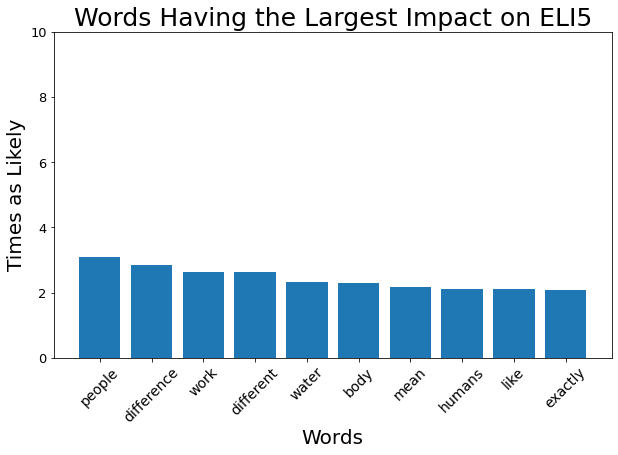

In [38]:
plt.figure(figsize = (10, 6))
# visualize top 10 words for eli5
plt.bar(eli5_words["words"],eli5_words["times_likely"])
plt.xlabel("Words",fontsize=20)
plt.ylabel("Times as Likely",fontsize=20)
plt.title("Words Having the Largest Impact on ELI5", fontsize=25)
plt.yticks(fontsize=13)
plt.xticks(rotation=45,fontsize=14)
plt.ylim([0,10]);

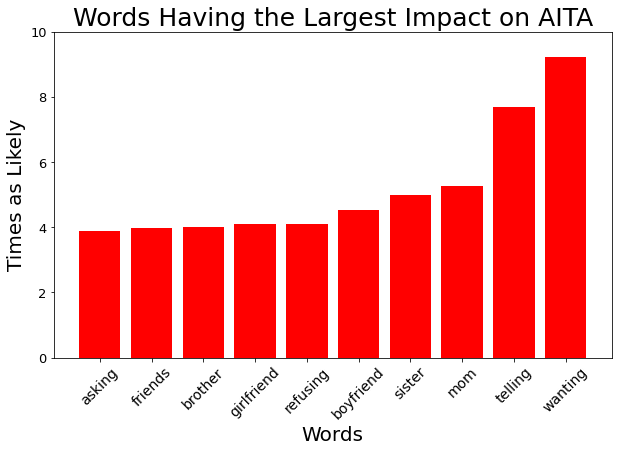

In [40]:
plt.figure(figsize = (10, 6))
# visualize top 10 words for each aita
plt.bar(aita_words["words"],aita_words["times_likely"],color="r")
plt.xlabel("Words",fontsize=20)
plt.ylabel("Times as Likely",fontsize=20)
plt.title("Words Having the Largest Impact on AITA", fontsize=25)
plt.yticks(fontsize=13)
plt.xticks(rotation=45,fontsize=14)
plt.ylim([0,10]);

## Fitting and tuning using logistic regression

In [9]:
lr = LogisticRegression(penalty="l2",solver="liblinear",C=.1)
cvector = CountVectorizer(stop_words=stopwords,
                         max_df=.8,
                         min_df=2,
                         max_features=2000)

vec_X_train = cvector.fit_transform(X_train)
vec_X_test = cvector.transform(X_test)

lr.fit(vec_X_train,y_train)
print(f'Training score {lr.score(vec_X_train,y_train)}')
print(f'Testing score {lr.score(vec_X_test,y_test)}')

Training score 0.9261538461538461
Testing score 0.9019230769230769
